In [51]:
import pandas as pd
import numpy as np
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from gensim.models import KeyedVectors, Word2Vec
from pathlib import Path
from datetime import datetime
from collections import Counter
import json
from sklearn.model_selection import GridSearchCV

In [52]:
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
sns.set_style('whitegrid')

try:
    russian_stopwords = stopwords.words('russian')
except:
    nltk.download('stopwords')
    russian_stopwords = stopwords.words('russian')

In [53]:
train_bodies = pd.read_csv('./data/train_bodies.csv')
test_bodies = pd.read_csv('./data/test_bodies.csv')

train_stances = pd.read_csv('./data/train_stances.csv')
test_stances = pd.read_csv('./data/test_stances_unlebeledb.csv') 

# Проведем предобработку данных

## Объединим данные

In [54]:
train_data = train_stances.merge(train_bodies, on='Body ID', how='left')
test_data = test_stances.merge(test_bodies, on='Body ID', how='left')

## Проведем предобработку русского языка

In [55]:
def preprocess_text(text):
    if not isinstance(text, str) or len(text) == 0:
        return ""
    
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^а-яё\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    words = text.split()
    words = [word for word in words if word not in russian_stopwords and len(word) > 2]
    
    return ' '.join(words)

## Обработка заголовков и текстов

In [56]:
train_data['headline_clean'] = train_data['Headline'].apply(preprocess_text)
train_data['body_clean'] = train_data['articleBody'].apply(preprocess_text)

test_data['headline_clean'] = test_data['Headline'].apply(preprocess_text)
test_data['body_clean'] = test_data['articleBody'].apply(preprocess_text)


## Создадим комбинированные признаки (заголовок + начало текста)

In [57]:
def combine_features(row):
    headline = row['headline_clean']
    body_words = row['body_clean'].split()
    body = ' '.join(body_words)
    return f"{headline} {body}"

In [58]:
train_data['combined_text'] = train_data.apply(combine_features, axis=1)
test_data['combined_text'] = test_data.apply(combine_features, axis=1)

In [59]:
train_data = train_data[train_data['combined_text'].str.len() > 10].reset_index(drop=True)
test_data = test_data[test_data['combined_text'].str.len() > 10].reset_index(drop=True)

In [60]:
train_data['text_length'] = train_data['combined_text'].str.split().str.len()
print(f"\nСтатистика длины комбинированных текстов (в словах):")
print(train_data['text_length'].describe())

train_data_tf = train_data


Статистика длины комбинированных текстов (в словах):
count    4408.000000
mean      136.134528
std        69.050534
min         9.000000
25%       101.000000
50%       126.000000
75%       153.000000
max      1084.000000
Name: text_length, dtype: float64


## Подготовим целевую переменную
---
где:
* Реальная новость - 1
* Фейк - 0

In [61]:
label_mapping = {'agree': 1, 'disagree': 0}

train_data['label'] = train_data['Stance'].map(label_mapping)
train_data.head(3)

,Unnamed: 0_x,Body ID,Headline,Stance,Headline1,Headline2,Unnamed: 0_y,articleBody,articleBody1,articleBody2,headline_clean,body_clean,combined_text,text_length,label
0,0,1,"['российский', 'бюджет', 'марте', 'недополучил...",agree,российский бюджет в марте недополучил более 30...,российский бюджет март недополучать миллиард р...,0,Разница между ожидаемыми по итогам марта нефте...,разница ожидаемыми итогам марта нефтегазовыми ...,разница ожидать итог март нефтегазовый доход ф...,российский бюджет марте недополучил миллиардов...,разница ожидаемыми итогам марта нефтегазовыми ...,российский бюджет марте недополучил миллиардов...,73,1
1,1,2,"['банк', 'россии', 'решил', 'снизить', 'ключев...",agree,банк россии решил снизить ключевую ставку с 20...,банк россия решать снижать ключевой ставка,1,Совет директоров Банка России решил снизить кл...,совет директоров банка россии решил снизить кл...,совет директор банк россия решать снижать ключ...,банк россии решил снизить ключевую ставку,совет директоров банка россии решил снизить кл...,банк россии решил снизить ключевую ставку сове...,57,1
2,2,3,"['мыс', 'идокопас', 'нато', 'назвали', 'первую...",disagree,мыс идокопас в нато назвали первую цель для н...,мыс идокопас нато называть первый цель начало ...,2,В НАТО составили наступательный план действий ...,нато составили наступательный план действий за...,нато составлять наступательный план действие з...,мыс идокопас нато назвали первую цель начала п...,нато составили наступательный план действий за...,мыс идокопас нато назвали первую цель начала п...,100,0


In [62]:
train_data_tf['label'] = train_data_tf['Stance'].map(label_mapping)
train_data_tf.head(3)

,Unnamed: 0_x,Body ID,Headline,Stance,Headline1,Headline2,Unnamed: 0_y,articleBody,articleBody1,articleBody2,headline_clean,body_clean,combined_text,text_length,label
0,0,1,"['российский', 'бюджет', 'марте', 'недополучил...",agree,российский бюджет в марте недополучил более 30...,российский бюджет март недополучать миллиард р...,0,Разница между ожидаемыми по итогам марта нефте...,разница ожидаемыми итогам марта нефтегазовыми ...,разница ожидать итог март нефтегазовый доход ф...,российский бюджет марте недополучил миллиардов...,разница ожидаемыми итогам марта нефтегазовыми ...,российский бюджет марте недополучил миллиардов...,73,1
1,1,2,"['банк', 'россии', 'решил', 'снизить', 'ключев...",agree,банк россии решил снизить ключевую ставку с 20...,банк россия решать снижать ключевой ставка,1,Совет директоров Банка России решил снизить кл...,совет директоров банка россии решил снизить кл...,совет директор банк россия решать снижать ключ...,банк россии решил снизить ключевую ставку,совет директоров банка россии решил снизить кл...,банк россии решил снизить ключевую ставку сове...,57,1
2,2,3,"['мыс', 'идокопас', 'нато', 'назвали', 'первую...",disagree,мыс идокопас в нато назвали первую цель для н...,мыс идокопас нато называть первый цель начало ...,2,В НАТО составили наступательный план действий ...,нато составили наступательный план действий за...,нато составлять наступательный план действие з...,мыс идокопас нато назвали первую цель начала п...,нато составили наступательный план действий за...,мыс идокопас нато назвали первую цель начала п...,100,0


# Word2Vec

## Загрузим эмбеддинги

In [63]:
sentences = [text.split() for text in train_data['body_clean']] + [text.split() for text in train_data['headline_clean']]
w2v = Word2Vec(sentences, vector_size=300, window=3, min_count=3, sg=1, workers=4, epochs=10)
kv = w2v.wv

## Функция для получения усреднённого вектора

In [64]:
def doc_vector(tokens, kv_model):
    vecs = [kv_model[w] for w in tokens if w in kv_model]
    if not vecs:
        return np.zeros(kv_model.vector_size, dtype=np.float32)
    return np.vstack(vecs).mean(axis=0)

## Соберем признаки: headline_vec, body_vec, косинусная близость

In [65]:
def cosine(u, v):
    nu, nv = np.linalg.norm(u), np.linalg.norm(v)
    if nu == 0 or nv == 0:
        return 0.0
    return float(np.dot(u, v) / (nu * nv))

def jaccard(a_tokens, b_tokens):
    A, B = set(a_tokens), set(b_tokens)
    if not A and not B:
        return 0.0
    return len(A & B) / max(1, len(A | B))

def overlap_ratio(a_tokens, b_tokens):
    A, B = set(a_tokens), set(b_tokens)
    if not A:
        return 0.0
    return len(A & B) / len(A)

def elementwise_stats(h_vec, b_vec):
    diff = np.abs(h_vec - b_vec)              
    prod = h_vec * b_vec                      
    l2 = np.linalg.norm(h_vec - b_vec)        
    return diff, prod, l2

def build_features(df, kv, max_len=150):
    H, B, COS, JAC, OVR, L2, DIFF, PROD = [], [], [], [], [], [], [], []
    for i, row in df.iterrows():
        htoks = row['headline_clean'].split()[:max_len]
        btoks = row['body_clean'].split()[:max_len]

        h_vec = doc_vector(htoks, kv)
        b_vec = doc_vector(btoks, kv)

        H.append(h_vec); B.append(b_vec)

        COS.append(cosine(h_vec, b_vec))
        JAC.append(jaccard(htoks, btoks))
        OVR.append(overlap_ratio(htoks, btoks))

        diff, prod, l2 = elementwise_stats(h_vec, b_vec)
        DIFF.append(diff); PROD.append(prod); L2.append(l2)

    H = np.vstack(H); B = np.vstack(B)
    COS = np.array(COS).reshape(-1, 1)
    JAC = np.array(JAC).reshape(-1, 1)
    OVR = np.array(OVR).reshape(-1, 1)
    L2  = np.array(L2).reshape(-1, 1)
    DIFF = np.vstack(DIFF)     # размер N, d
    PROD = np.vstack(PROD)     # размер N, d

    X = np.hstack([H, B, DIFF, PROD, COS, JAC, OVR, L2])
    return X

## Подготовка X и y

In [66]:
X = build_features(train_data, kv)
y = train_data['label'].values

## Разделим

In [67]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Обучим модель логистической регрессии и рандомного леса. Прогоним по метрикам

In [68]:
models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1)
}

Path("models").mkdir(parents=True, exist_ok=True)

In [69]:
param_grids = {
    'LogisticRegression': {
        'C': [0.1, 0.5, 1, 2, 5],
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [500, 1000, 2000],
        'class_weight': ['balanced', None]
    },
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced']
    }
}

In [70]:
results = {}
metrics_dict = {}

for name, model in models.items():
    print(f"\n--- {name}: подбор гиперпараметров ---")

    grid = GridSearchCV(model, param_grids[name], cv=3,
                        scoring='f1_weighted', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_

    # Предсказания
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)

    # Метрики
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')

    print(f"Лучшие параметры: {grid.best_params_}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Val Accuracy:   {val_acc:.4f}")
    print(f"Val F1-Score:   {val_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_val_pred,
                                target_names=['Фейк (disagree)', 'Реальная (agree)'],
                                digits=4))

    # Сохранение модели
    model_name = name.lower().replace(" ", "_")
    with open(f"models/{model_name}_best_model.pkl", "wb") as f:
        pickle.dump(best_model, f)

    results[name] = {
        'best_params': grid.best_params_,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_f1': val_f1
    }

    metrics_dict[model_name] = {
        "val_accuracy": val_acc,
        "val_f1": val_f1,
        "best_params": grid.best_params_
    }

Path("results/metrics").mkdir(parents=True, exist_ok=True)
with open("results/metrics/metrics_w2v.json", "w", encoding="utf-8") as f:
    json.dump(metrics_dict, f, ensure_ascii=False, indent=4)

# Эмбеддинги
kv.save("models/w2v_vectors.kv")


--- LogisticRegression: подбор гиперпараметров ---
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Лучшие параметры: {'C': 5, 'class_weight': 'balanced', 'max_iter': 500, 'solver': 'lbfgs'}
Train Accuracy: 0.9546
Val Accuracy:   0.9127
Val F1-Score:   0.9127

Classification Report:
                  precision    recall  f1-score   support

 Фейк (disagree)     0.9124    0.9144    0.9134       444
Реальная (agree)     0.9130    0.9110    0.9120       438

        accuracy                         0.9127       882
       macro avg     0.9127    0.9127    0.9127       882
    weighted avg     0.9127    0.9127    0.9127       882


--- RandomForest: подбор гиперпараметров ---
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Лучшие параметры: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 300}
Train Accuracy: 0.9980
Val Accuracy:   0.9240
Val F1-Score:   0.9240

Classification Report:
                  precision    recall  f

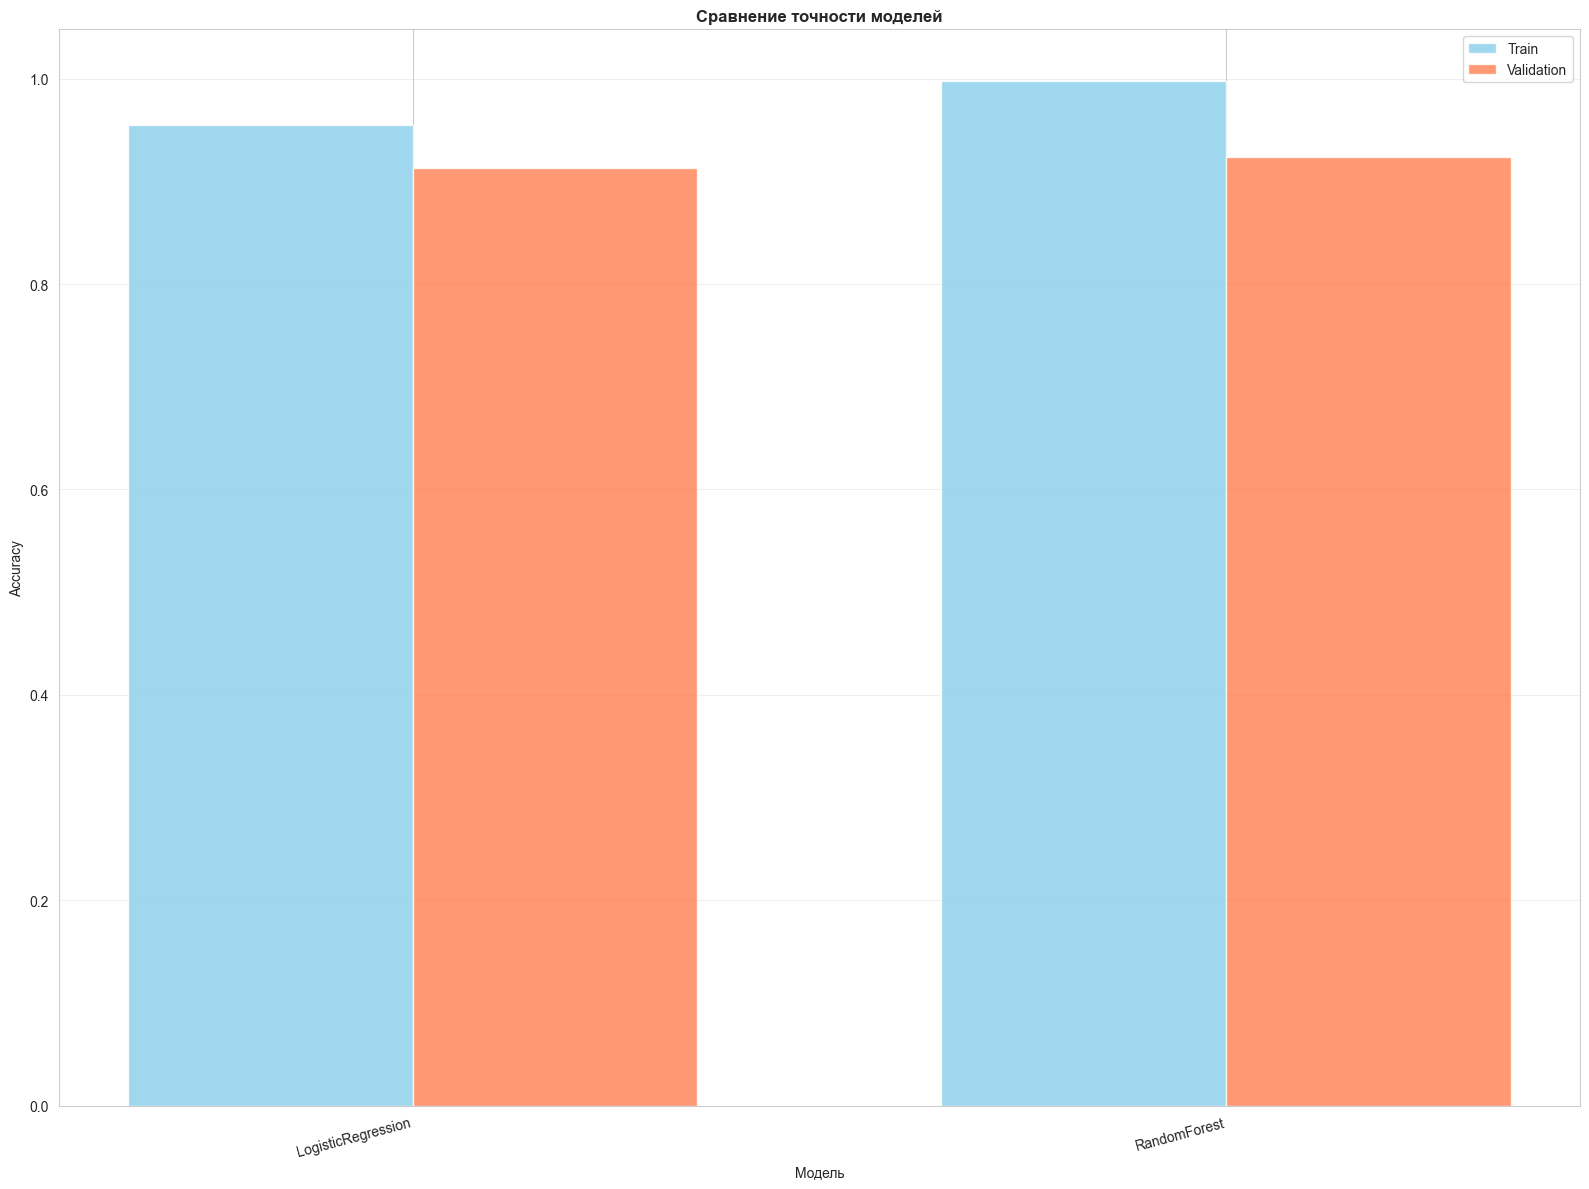

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

model_names = list(results.keys())
train_accs = [results[name]['train_acc'] for name in model_names]
val_accs = [results[name]['val_acc'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

ax.bar(x - width/2, train_accs, width, label='Train', alpha=0.8, color='skyblue')
ax.bar(x + width/2, val_accs, width, label='Validation', alpha=0.8, color='coral')
ax.set_xlabel('Модель')
ax.set_ylabel('Accuracy')
ax.set_title('Сравнение точности моделей', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./assets/models_scores_w2v.png', dpi=300)

## Сохраним модель, эмбеддинги и метаданные

# TF-IDF

## Разделим данные

In [72]:
X = train_data_tf['combined_text']
y = train_data_tf['label']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [73]:
print(f"\nРаспределение классов в train:")
print(y_train.value_counts())
print(f"\nРаспределение классов в validation:")
print(y_val.value_counts())


Распределение классов в train:
label
0    1777
1    1749
Name: count, dtype: int64

Распределение классов в validation:
label
0    444
1    438
Name: count, dtype: int64


## Векторизация

In [74]:
vectorizer = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),  
    min_df=3,
    max_df=0.85,
    sublinear_tf=True
)

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)

print(f"✓ Размерность векторов: {X_train_vec.shape[1]} признаков")
print(f"✓ Разреженность: {(1 - X_train_vec.nnz / (X_train_vec.shape[0] * X_train_vec.shape[1])) * 100:.2f}%")

✓ Размерность векторов: 8000 признаков
✓ Разреженность: 98.97%


## Обучим 3 модели и в последствии выберем лучшую
---
* Logistic Regression
* Naive Bayes
* Random Forest

In [81]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1)
}

In [82]:
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 0.5, 1, 2, 5],
        'solver': ['liblinear', 'lbfgs'],
        'max_iter': [500, 1000, 2000],
        'class_weight': ['balanced', None]
    },
    'Naive Bayes': {
        'alpha': [0.01, 0.1, 0.5, 1.0]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced']
    }
}

In [83]:
results = {}
metrics_dict = {}

# Цикл по моделям с подбором гиперпараметров
for name, model in models.items():
    print(f"\n--- {name}: подбор гиперпараметров ---")

    grid = GridSearchCV(model, param_grids[name],
                        cv=3, scoring='f1_weighted',
                        n_jobs=-1, verbose=1)
    grid.fit(X_train_vec, y_train)

    best_model = grid.best_estimator_

    # Предсказания
    y_train_pred = best_model.predict(X_train_vec)
    y_val_pred = best_model.predict(X_val_vec)

    # Метрики
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')

    print(f"Лучшие параметры: {grid.best_params_}")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Val Accuracy:   {val_acc:.4f}")
    print(f"Val F1-Score:   {val_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(
        y_val, y_val_pred,
        target_names=['Фейк (disagree)', 'Реальная (agree)'],
        digits=4
    ))

    # Сохраняем результаты и модели
    model_name = name.lower().replace(" ", "_")
    results[name] = {
        'best_params': grid.best_params_,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'val_f1': val_f1
    }
    metrics_dict[model_name] = {
        "val_accuracy": val_acc,
        "val_f1": val_f1,
        "best_params": grid.best_params_
    }


--- Logistic Regression: подбор гиперпараметров ---
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Лучшие параметры: {'C': 5, 'class_weight': 'balanced', 'max_iter': 500, 'solver': 'lbfgs'}
Train Accuracy: 0.9983
Val Accuracy:   0.9603
Val F1-Score:   0.9603

Classification Report:
                  precision    recall  f1-score   support

 Фейк (disagree)     0.9455    0.9775    0.9612       444
Реальная (agree)     0.9764    0.9429    0.9593       438

        accuracy                         0.9603       882
       macro avg     0.9609    0.9602    0.9603       882
    weighted avg     0.9608    0.9603    0.9603       882


--- Naive Bayes: подбор гиперпараметров ---
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Лучшие параметры: {'alpha': 1.0}
Train Accuracy: 0.9606
Val Accuracy:   0.9365
Val F1-Score:   0.9364

Classification Report:
                  precision    recall  f1-score   support

 Фейк (disagree)     0.9145    0.9640    0.9386       444
Ре

## Проверим на метриках

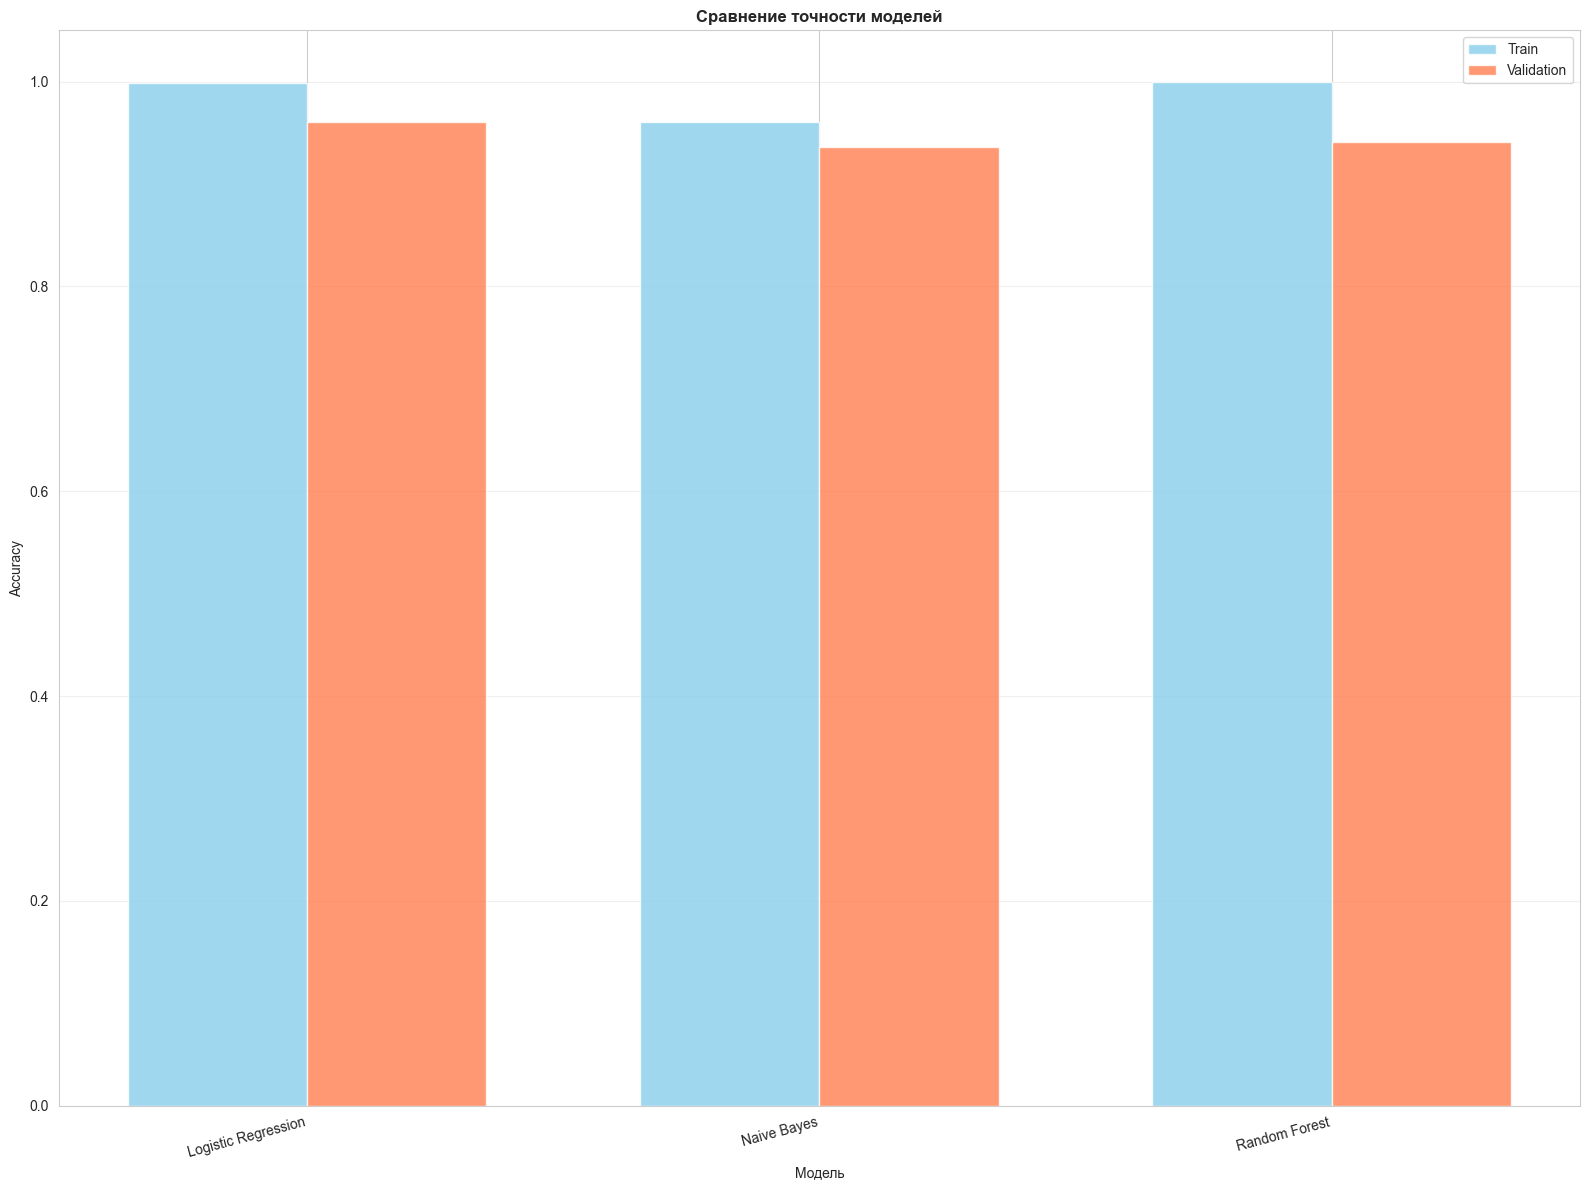

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

model_names = list(results.keys())
train_accs = [results[name]['train_acc'] for name in model_names]
val_accs = [results[name]['val_acc'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

ax.bar(x - width/2, train_accs, width, label='Train', alpha=0.8, color='skyblue')
ax.bar(x + width/2, val_accs, width, label='Validation', alpha=0.8, color='coral')
ax.set_xlabel('Модель')
ax.set_ylabel('Accuracy')
ax.set_title('Сравнение точности моделей', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./assets/models_scores.png', dpi=300)


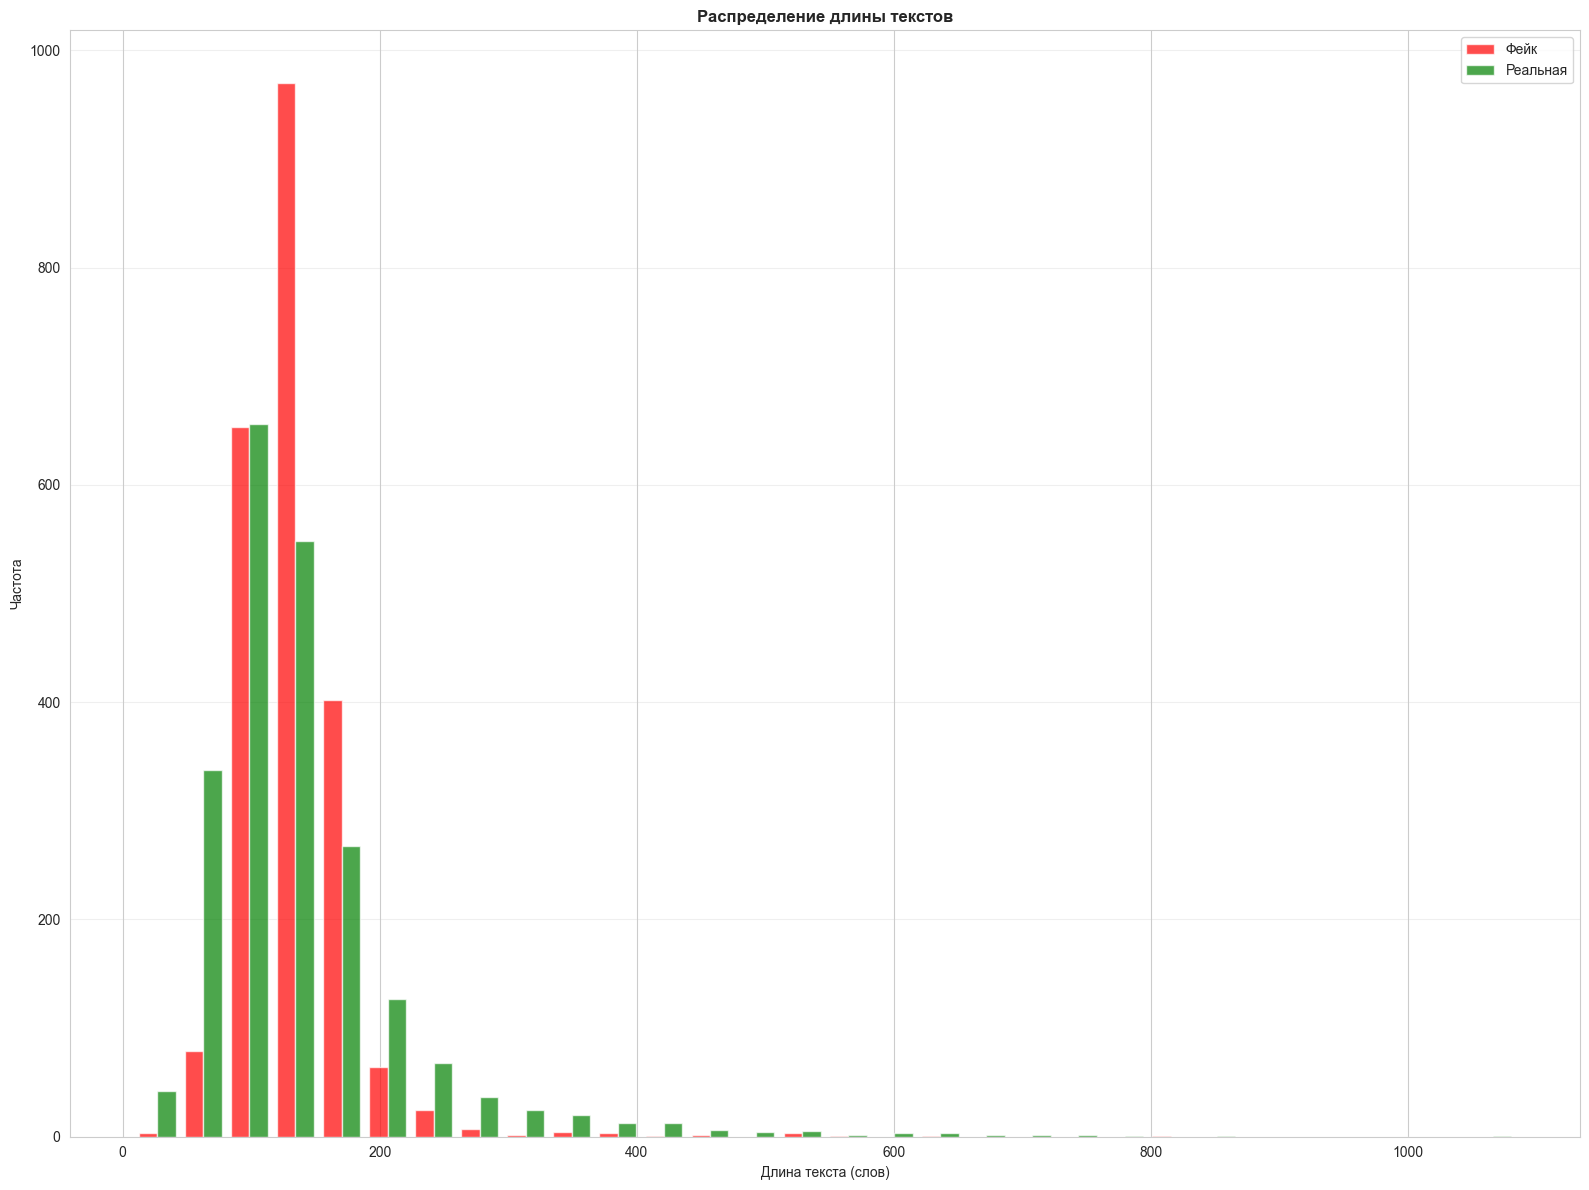

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

ax.hist(
    [train_data_tf[train_data_tf['label']==0]['text_length'],
     train_data_tf[train_data_tf['label']==1]['text_length']],
    bins=30, label=['Фейк', 'Реальная'], alpha=0.7, color=['red', 'green']
)
ax.set_xlabel('Длина текста (слов)')
ax.set_ylabel('Частота')
ax.set_title('Распределение длины текстов', fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('./assets/text_lenght.png', dpi=300)

## Сохраним модели

In [86]:
for name, info in results.items():
    model = info['model']
    filename = f'./models/{name}_model_tf.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Модель {name} сохранена в {filename}")

# Также сохраняем векторизатор и лейблы (общие для всех моделей)
with open('./models/tfidf_vectorizer_tf.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('./models/label_mapping_tf.pkl', 'wb') as f:
    pickle.dump(label_mapping, f)


KeyError: 'model'

In [87]:
from pathlib import Path

# Формируем словарь метрик
metrics = {
    model_name: {
        "val_acc": results[model_name]["val_acc"]
    }
    for model_name in results
}

# Создаём каталог, если его нет
Path("results/metrics").mkdir(parents=True, exist_ok=True)

# Сохраняем метрики в JSON
with open("results/metrics/metrics.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

print("Метрики сохранены в results/metrics/metrics.json")


Метрики сохранены в results/metrics/metrics.json
